In [1]:
# BATCH:256
# batch_size:256
# data_path:"/data2"
# decay:0.7834769413661389
# EPOCH:20
# hard_reset:true
# IMAGE_SIZE:32
# learning_rate:0.007176761798504128
# pre_spike_weight:5.165214142219577
# rate_coding:true
# TIME_STEP:9
# time_step:9
# v_decay:0.7834769413661389
# v_reset:0
# v_threshold:1
# which_data:"CIFAR10"


# BATCH:256
# batch_size:256
# data_path:"/data2"
# decay:0.38993471232202725
# EPOCH:20
# hard_reset:true
# IMAGE_SIZE:28
# learning_rate:0.06285718352377828
# pre_spike_weight:6.21970124592063
# rate_coding:true
# TIME_STEP:16
# time_step:16
# v_decay:0.38993471232202725
# v_reset:0
# v_threshold:1
# which_data:"MNIST"

# BATCH:64
# batch_size:64
# data_path:"/data2"
# decay:0.9266077968579136
# EPOCH:20
# hard_reset:true
# IMAGE_SIZE:28
# learning_rate:0.07732456724854177
# pre_spike_weight:1.5377416716615555
# rate_coding:true
# TIME_STEP:7
# time_step:7
# v_decay:0.9266077968579136
# v_reset:0
# v_threshold:1
# which_data:"FASHION_MNIST"

In [2]:
# Copyright (c) 2024 Byeonghyeon Kim 
# github site: https://github.com/bhkim003/ByeonghyeonKim
# email: bhkim003@snu.ac.kr
 
# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:
 
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
 
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.


In [3]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
import torchvision.datasets
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt


from snntorch import spikegen

 
import wandb

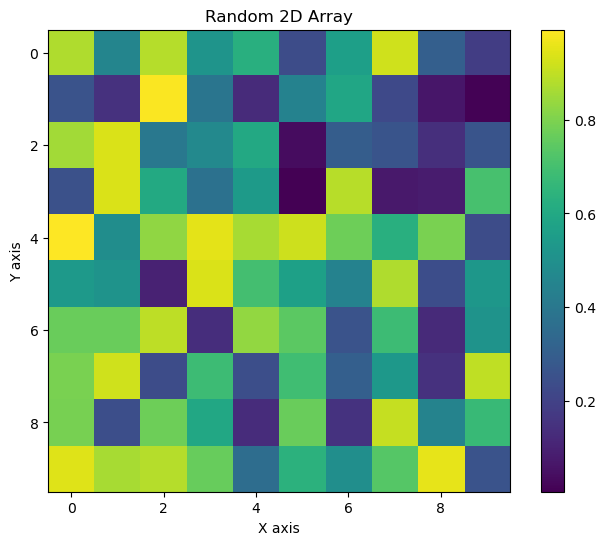

In [4]:
# my module import
from modules import *

In [5]:
    
class RESERVOIR(nn.Module):
    def __init__ (self, TIME_STEP=8, in_spike_size=28, in_channel=1, receptive_size=3, v_init=0, v_decay=0.6, v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1):
        super(RESERVOIR, self).__init__()
        self.TIME_STEP = TIME_STEP
        self.in_spike_size = in_spike_size
        self.in_channel = in_channel
        self.receptive_size = receptive_size #3
        self.v_init = v_init
        self.v_decay = v_decay
        self.v_threshold = v_threshold
        self.v_reset = v_reset
        self.hard_reset = hard_reset
        self.pre_spike_weight = pre_spike_weight

        self.out_channel = 1

        # 파라미터 
        self.conv_depthwise = nn.Conv2d(in_channels=self.in_channel, out_channels=self.in_channel, 
                                        kernel_size=self.receptive_size, 
                                        stride=1, padding=1, groups=self.in_channel)

        # kaiming 초기화
        nn.init.kaiming_normal_(self.conv_depthwise.weight, mode='fan_out', nonlinearity='relu')
        nn.init.constant_(self.conv_depthwise.bias, 0)

        # membrane potential 초기화
        self.v = torch.full((self.in_channel, self.in_spike_size, self.in_spike_size), fill_value=self.v_init, requires_grad=False)

        
    def forward(self, pre_spike):    
        # pre_spike [TIME_STEP, batch_size, in_channel, in_spike_size, in_spike_size]

        v = torch.full_like(pre_spike[0], fill_value=self.v_init, requires_grad=False)
        post_spike = torch.zeros_like(pre_spike[0], requires_grad=False)
        # v [batch_size, in_channel, in_spike_size, in_spike_size]
        # recurrent [batch_size, in_channel, in_spike_size, in_spike_size]

        # timestep 안 맞으면 종료
        assert pre_spike.size(0) == self.TIME_STEP, f"Time step mismatch: {pre_spike.size(0)} vs {self.TIME_STEP}"

        output = []
        for t in range (self.TIME_STEP):
            # pre_spike[t] [batch_size, in_channel, in_spike_size, in_spike_size]
            input_current = self.pre_spike_weight * pre_spike[t]
            recurrent_current = self.conv_depthwise(post_spike)
            current = input_current + recurrent_current
            # current [batch_size, in_channel, in_spike_size, in_spike_size] # kernel size 3이니까 사이즈 유지
            
            # decay and itegrate
            v = v*self.v_decay + current

            # post spike
            post_spike = (v >= self.v_threshold).float()

            output.append(post_spike)
            
            #reset
            if self.hard_reset: # hard reset
                v = (1 - post_spike)*v + post_spike*self.v_reset 
            else: # soft reset
                v = v - post_spike*self.v_threshold

        output = torch.stack(output, dim=0)
        return output

In [6]:
class NO_RESERVOIR_NET(nn.Module):
    def __init__(self, TIME_STEP=8, CLASS_NUM=10, in_spike_size=28, in_channel=1, receptive_size=3, v_init=0, v_decay=0.6, v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1):
        super(NO_RESERVOIR_NET, self).__init__()
        self.TIME_STEP = TIME_STEP
        self.reservoir = RESERVOIR(TIME_STEP = self.TIME_STEP, in_spike_size=in_spike_size, in_channel=in_channel, receptive_size=receptive_size, v_init=v_init, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, hard_reset=hard_reset, pre_spike_weight=pre_spike_weight)
        self.linear = nn.Linear(in_features=in_channel*in_spike_size*in_spike_size, out_features=CLASS_NUM)

    def forward(self, x):
        # x size [batch_size, TIME_STEP, in_channel, in_spike_size, in_spike_size]
        x = x.permute(1,0,2,3,4)
        # x size [TIME_STEP, batch_size, in_channel, in_spike_size, in_spike_size]

        # with torch.no_grad():
        #     x = self.reservoir(x) # reservoir weight는 학습 안함

        T, B, *spatial_dims = x.shape
        x = x.reshape(T * B, -1) # time,batch 축은 합쳐서 FC에 삽입

        x = self.linear(x)

        x = x.view(T , B, -1).contiguous() 
        
        x = x.mean(dim=0)
        return x

In [7]:
class RESERVOIR_NET(nn.Module):
    def __init__(self, TIME_STEP=8, CLASS_NUM=10, in_spike_size=28, in_channel=1, receptive_size=3, v_init=0, v_decay=0.6, v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1):
        super(RESERVOIR_NET, self).__init__()
        self.TIME_STEP = TIME_STEP
        self.reservoir = RESERVOIR(TIME_STEP = self.TIME_STEP, in_spike_size=in_spike_size, in_channel=in_channel, receptive_size=receptive_size, v_init=v_init, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, hard_reset=hard_reset, pre_spike_weight=pre_spike_weight)
        self.linear = nn.Linear(in_features=in_channel*in_spike_size*in_spike_size, out_features=CLASS_NUM)

    def forward(self, x):
        # x size [batch_size, TIME_STEP, in_channel, in_spike_size, in_spike_size]
        x = x.permute(1,0,2,3,4)
        # x size [TIME_STEP, batch_size, in_channel, in_spike_size, in_spike_size]

        with torch.no_grad():
            x = self.reservoir(x) # reservoir weight는 학습 안함

        T, B, *spatial_dims = x.shape
        x = x.reshape(T * B, -1) # time,batch 축은 합쳐서 FC에 삽입

        x = self.linear(x)

        x = x.view(T , B, -1).contiguous() 
        
        x = x.mean(dim=0)
        return x

In [8]:
def data_loader(which_data, data_path, rate_coding, BATCH, IMAGE_SIZE, TIME, dvs_duration, dvs_clipping):
    if which_data == 'MNIST':
        if rate_coding :
            transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0,), (1,))])
        else : 
            transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,),(0.5))])

        trainset = torchvision.datasets.MNIST(root=data_path,
                                            train=True,
                                            download=True,
                                            transform=transform)


        testset = torchvision.datasets.MNIST(root=data_path,
                                            train=False,
                                            download=True,
                                            transform=transform)

        train_loader = DataLoader(trainset,
                                batch_size =BATCH,
                                shuffle = True,
                                num_workers =2)
        test_loader = DataLoader(testset,
                                batch_size =BATCH,
                                shuffle = False,
                                num_workers =2)
        synapse_conv_in_channels = 1
        CLASS_NUM = 10


    

    elif (which_data == 'CIFAR10'):

        if rate_coding :
            # transform_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            #                                     transforms.RandomHorizontalFlip(),
            #                                     transforms.ToTensor()])

            # transform_test = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            #                                     transforms.ToTensor()])
            
            transform_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor()])
                                            # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

            transform_test = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                                transforms.ToTensor()])
        
        else :
            # transform_train = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            #                                     transforms.RandomHorizontalFlip(),
            #                                     transforms.ToTensor(),
            #                                     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
            #                                 # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

            # transform_test = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
            #                                     transforms.ToTensor(),
            #                                     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),])
            #                                 # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            
            # assert IMAGE_SIZE == 32, 'OTTT랑 맞짱뜰 때는 32로 ㄱ'
            transform_train = transforms.Compose([
                transforms.RandomCrop(IMAGE_SIZE, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465),
                                    (0.2023, 0.1994, 0.2010)),
            ])
            transform_test = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465),
                                    (0.2023, 0.1994, 0.2010)),
            ])

        trainset = torchvision.datasets.CIFAR10(root=data_path,
                                            train=True,
                                            download=True,
                                            transform=transform_train)


        testset = torchvision.datasets.CIFAR10(root=data_path,
                                            train=False,
                                            download=True,
                                            transform=transform_test)
        
        
        train_loader = DataLoader(trainset,
                                batch_size =BATCH,
                                shuffle = True,
                                num_workers =2)
        test_loader = DataLoader(testset,
                                batch_size =BATCH,
                                shuffle = False,
                                num_workers =2)
        
        synapse_conv_in_channels = 3
        CLASS_NUM = 10
        '''
        classes = ('plane', 'car', 'bird', 'cat', 'deer',
                'dog', 'frog', 'horse', 'ship', 'truck') 
        '''


    elif (which_data == 'FASHION_MNIST'):

        if rate_coding :
            transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                    transforms.ToTensor()])
        else : 
            transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.5,),(0.5))])

        trainset = torchvision.datasets.FashionMNIST(root=data_path,
                                            train=True,
                                            download=True,
                                            transform=transform)


        testset = torchvision.datasets.FashionMNIST(root=data_path,
                                            train=False,
                                            download=True,
                                            transform=transform)

        train_loader = DataLoader(trainset,
                                batch_size =BATCH,
                                shuffle = True,
                                num_workers =2)
        test_loader = DataLoader(testset,
                                batch_size =BATCH,
                                shuffle = False,
                                num_workers =2)
        synapse_conv_in_channels = 1
        CLASS_NUM = 10
    elif (which_data == 'DVS_GESTURE'):
        data_dir = data_path + '/gesture'
        transform = None

        # # spikingjelly.datasets.dvs128_gesture.DVS128Gesture(root: str, train: bool, use_frame=True, frames_num=10, split_by='number', normalization='max')
       
        #https://spikingjelly.readthedocs.io/zh-cn/latest/activation_based_en/neuromorphic_datasets.html
        # 10ms마다 1개의 timestep하고 싶으면 위의 주소 참고. 근데 timestep이 각각 좀 다를 거임.

        
        if dvs_duration > 0:
            resize_shape = (IMAGE_SIZE, IMAGE_SIZE)
            train_data = CustomDVS128Gesture(
                data_dir, train=True, data_type='frame',  split_by='time',  duration=dvs_duration, resize_shape=resize_shape, dvs_clipping=dvs_clipping, dvs_duration_copy=dvs_duration, TIME=TIME)
            test_data = CustomDVS128Gesture(
                data_dir, train=False, data_type='frame',  split_by='time',  duration=dvs_duration, resize_shape=resize_shape, dvs_clipping=dvs_clipping, dvs_duration_copy=dvs_duration, TIME=TIME)

        else:
            train_data = CustomDVS128Gesture(
                data_dir, train=True, data_type='frame', split_by='number', frames_number=TIME, resize_shape=resize_shape, dvs_clipping=dvs_clipping, dvs_duration_copy=dvs_duration, TIME=TIME)
            test_data = CustomDVS128Gesture(data_dir, train=False,
                                            data_type='frame', split_by='number', frames_number=TIME, resize_shape=resize_shape, dvs_clipping=dvs_clipping, dvs_duration_copy=dvs_duration, TIME=TIME)
        
        exclude_class = 10
        train_indices = [i for i, (_, target) in enumerate(train_data) if target != exclude_class]
        test_indices = [i for i, (_, target) in enumerate(test_data) if target != exclude_class]
    
        # SubsetRandomSampler 생성
        train_sampler = SubsetRandomSampler(train_indices)
        test_sampler = SequentialSampler(test_indices)

        # ([B, T, 2, 128, 128]) 
        train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH, num_workers=2, sampler=train_sampler, collate_fn=pad_sequence_collate)
        test_loader = torch.utils.data.DataLoader(dataset=test_data, batch_size=BATCH, num_workers=2, sampler=test_sampler, collate_fn=pad_sequence_collate)
        synapse_conv_in_channels = 2
        CLASS_NUM = 10
        # mapping = { 0 :'Hand Clapping'  1 :'Right Hand Wave'2 :'Left Hand Wave' 3 :'Right Arm CW'   4 :'Right Arm CCW'  5 :'Left Arm CW'    6 :'Left Arm CCW'   7 :'Arm Roll'       8 :'Air Drums'      9 :'Air Guitar'     10:'Other'}


    else:
        assert False, 'wrong dataset name'


    
    return train_loader, test_loader, synapse_conv_in_channels, CLASS_NUM

In [9]:
def train(model, train_loader, criterion, optimizer, device, rate_coding, TIME_STEP, which_data):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    iterator = enumerate(train_loader, 0)
    for i, data in iterator:
    # for i, (inputs, labels) in enumerate(train_loader):
        if len(data) == 2:
            inputs, labels = data
            # 처리 로직 작성
        elif len(data) == 3:
            inputs, labels, x_len = data

        inputs, labels = inputs.to(device), labels.to(device)

        # if rate_coding == True:
        #     inputs = spikegen.rate(inputs, num_steps=TIME_STEP)
        # else:
        #     inputs = inputs.repeat(TIME_STEP, 1, 1, 1, 1)
        

        ###########################################################################################################################        
        if (which_data == 'n_tidigits'):
            inputs = inputs.permute(0, 1, 3, 2, 4)
            labels = labels[:, 0, :]
            labels = torch.argmax(labels, dim=1)
        elif (which_data == 'heidelberg'):
            inputs = inputs.view(5, 1000, 1, 700, 1)
            print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
        # print('inputs',inputs.size(),'\nlabels',labels.size())
        # print(labels)
            
        if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
            inputs = inputs.permute(1, 0, 2, 3, 4)
        elif rate_coding == True :
            inputs = spikegen.rate(inputs, num_steps=TIME_STEP)
        else :
            inputs = inputs.repeat(TIME_STEP, 1, 1, 1, 1)
        # inputs: [Time, Batch, Channel, Height, Width]  
        ####################################################################################################################### 

        
        
        
        
        inputs = inputs.permute(1, 0, 2, 3, 4)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        iter_correct = (predicted == labels).sum().item()
        correct += iter_correct
        # if i % 100 == 99:
        # print(f"[{i+1}] loss: {running_loss / 100:.3f}")
        # running_loss = 0.0
        iter_accuracy = 100 * iter_correct / labels.size(0)
        wandb.log({"iter_accuracy": iter_accuracy})
    tr_accuracy = 100 * correct / total         
    wandb.log({"tr_accuracy": tr_accuracy})
    print(f"Train Accuracy: {tr_accuracy:.2f}%")
    
def test(model, test_loader, criterion, device, rate_coding, TIME_STEP, which_data):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    iterator = enumerate(test_loader, 0)
    with torch.no_grad():
        for i, data in iterator:
        # for inputs, labels in test_loader:
            if len(data) == 2:
                inputs, labels = data
                # 처리 로직 작성
            elif len(data) == 3:
                inputs, labels, x_len = data
                
            inputs, labels = inputs.to(device), labels.to(device)

            # if rate_coding == True:
            #     inputs = spikegen.rate(inputs, num_steps=TIME_STEP)
            # else:
            #     inputs = inputs.repeat(TIME_STEP, 1, 1, 1, 1)

        

            ###########################################################################################################################        
            if (which_data == 'n_tidigits'):
                inputs = inputs.permute(0, 1, 3, 2, 4)
                labels = labels[:, 0, :]
                labels = torch.argmax(labels, dim=1)
            elif (which_data == 'heidelberg'):
                inputs = inputs.view(5, 1000, 1, 700, 1)
                print("\n\n\n경고!!!! heidelberg 이거 타임스텝이랑 채널 잘 바꿔줘라!!!\n\n\n\n")
            # print('inputs',inputs.size(),'\nlabels',labels.size())
            # print(labels)
                
            if (which_data == 'DVS_CIFAR10' or which_data == 'DVS_GESTURE' or which_data == 'DVS_CIFAR10_2' or which_data == 'NMNIST' or which_data == 'N_CALTECH101' or which_data == 'n_tidigits' or which_data == 'heidelberg'):
                inputs = inputs.permute(1, 0, 2, 3, 4)
            elif rate_coding == True :
                inputs = spikegen.rate(inputs, num_steps=TIME_STEP)
            else :
                inputs = inputs.repeat(TIME_STEP, 1, 1, 1, 1)
            # inputs: [Time, Batch, Channel, Height, Width]  
            ####################################################################################################################### 

        


            inputs = inputs.permute(1, 0, 2, 3, 4)
        
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_accuracy = 100 * correct / total
    wandb.log({"val_accuracy": val_accuracy})
    print(f"Test loss: {test_loss / len(test_loader):.3f}, Accuracy: {val_accuracy:.2f}%")


In [10]:
def main(data_path='/data2', which_data='MNIST', gpu = '3',learning_rate = 0.0001, BATCH=5, IMAGE_SIZE=28, TIME_STEP=8, EPOCH=10, rate_coding=True, v_decay= 0.6,
v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1, dvs_duration=1000000, dvs_clipping=True, no_reservoir = False):
    os.environ["CUDA_VISIBLE_DEVICES"]= gpu
    # run = wandb.init(project=f'reservoir')

    hyperparameters = locals()

    wandb.config.update(hyperparameters)
    wandb.run.name = f'{which_data}_sweeprun_epoch{EPOCH}'
    wandb.run.log_code(".", include_fn=lambda path: path.endswith(".py") or path.endswith(".ipynb"))

    train_loader, test_loader, in_channel, CLASS_NUM = data_loader(
        which_data=which_data, data_path=data_path, rate_coding=rate_coding, BATCH=BATCH, IMAGE_SIZE=IMAGE_SIZE, TIME=TIME_STEP, dvs_duration=dvs_duration, dvs_clipping=dvs_clipping)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if no_reservoir == True:
        net = NO_RESERVOIR_NET(TIME_STEP=TIME_STEP, CLASS_NUM=CLASS_NUM, in_spike_size=IMAGE_SIZE, in_channel=in_channel, receptive_size=3, v_init=0, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, hard_reset=hard_reset, pre_spike_weight=pre_spike_weight)
    else:
        net = RESERVOIR_NET(TIME_STEP=TIME_STEP, CLASS_NUM=CLASS_NUM, in_spike_size=IMAGE_SIZE, in_channel=in_channel, receptive_size=3, v_init=0, v_decay=v_decay, v_threshold=v_threshold, v_reset=v_reset, hard_reset=hard_reset, pre_spike_weight=pre_spike_weight)
    net = net.to(device)
    wandb.watch(net, log="all", log_freq = 1) #gradient, parameter logging해줌

    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=0)

    print(net)

    for epoch in range(EPOCH):
        print(f"Epoch {epoch+1}")
        train(net, train_loader, criterion, optimizer, device, rate_coding, TIME_STEP, which_data)
        test(net, test_loader, criterion, device, rate_coding, TIME_STEP, which_data)
        # torch.save(net.state_dict(), 'net_save/reservoir_net.pth')
        # artifact = wandb.Artifact('model', type='model')
        # artifact.add_file('net_save/reservoir_net.pth')
        # run.log_artifact(artifact)


In [11]:
# # sweep 하기 싫을 때
# wandb.init(project=f'reservoir')
# main(data_path='/data2', which_data='CIFAR10', gpu = '3', learning_rate = 0.0072, BATCH=256, IMAGE_SIZE=32, TIME_STEP=9, EPOCH=50, rate_coding=True, v_decay= 0.78,
# v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=5.0, dvs_duration=1000000, dvs_clipping=True, no_reservoir = False)

In [12]:
# sweep하고싶을 때
def sweep_cover(data_path='/data2', which_data='CIFAR10', gpu = '3', learning_rate = 0.0001, BATCH=5, IMAGE_SIZE=28, TIME_STEP=8, EPOCH=3, rate_coding=True, v_decay= 0.6,
v_threshold=1, v_reset=0, hard_reset=True, pre_spike_weight=1, dvs_duration=1000000, dvs_clipping=True, no_reservoir = False):
    
    wandb.init(save_code = True)

    learning_rate  =  wandb.config.learning_rate
    BATCH  =  wandb.config.batch_size
    TIME_STEP  =  wandb.config.time_step
    v_decay  =  wandb.config.decay
    pre_spike_weight  =  wandb.config.pre_spike_weight
    which_data  =  wandb.config.which_data
    data_path  =  wandb.config.data_path
    rate_coding  =  wandb.config.rate_coding
    EPOCH  =  wandb.config.EPOCH
    IMAGE_SIZE  =  wandb.config.IMAGE_SIZE
    dvs_duration  =  wandb.config.dvs_duration
    dvs_clipping  =  wandb.config.dvs_clipping
    no_reservoir  =  wandb.config.no_reservoir
    main(data_path=data_path, which_data=which_data, gpu = gpu, learning_rate = learning_rate, BATCH=BATCH, IMAGE_SIZE=IMAGE_SIZE, TIME_STEP=TIME_STEP, EPOCH=EPOCH, rate_coding=rate_coding, v_decay= v_decay,
v_threshold=v_threshold, v_reset=v_reset, hard_reset=hard_reset, pre_spike_weight=pre_spike_weight, dvs_duration=dvs_duration, dvs_clipping=dvs_clipping, no_reservoir = no_reservoir)



which_data_hyper = 'DVS_GESTURE' # 'MNIST', 'CIFAR10' ', 'FASHION_MNIST', 'DVS_GESTURE'
data_path_hyper = '/data2'

sweep_configuration = {
    'method': 'bayes',
    'name': which_data_hyper,
    'metric': {'goal': 'maximize', 'name': 'val_accuracy'},
    'parameters': 
    {
        "learning_rate": {"min": 0.00001, "max": 0.1},
        "batch_size": {"values": [16, 32, 64, 128, 256]},
        "time_step": {"values": [4,5,6,7,8]},
        "decay": {"min": 0.25, "max": 1.0},
        "pre_spike_weight": {"min": 0.5, "max": 10.0},
        "which_data": {"values": [which_data_hyper]},
        "data_path": {"values": [data_path_hyper]},
        "rate_coding": {"values": [True, False]},
        "EPOCH": {"values": [50]},
        "IMAGE_SIZE": {"values": [16,32,48,128]},
        "dvs_duration": {"values": [1000000]},
        "dvs_clipping": {"values": [True]},
        "no_reservoir": {"values": [True, False]},
     }
}

sweep_id = wandb.sweep(sweep=sweep_configuration, project=f'reservoir')
wandb.agent(sweep_id, function=sweep_cover, count=10000)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: 0j0aowy8
Sweep URL: https://wandb.ai/bhkim003-seoul-national-university/reservoir/sweeps/0j0aowy8


wandb: Agent Starting Run: zcsmk58c with config:
wandb: 	EPOCH: 50
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.6266195342405995
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.012550985229680452
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.801503080443608
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: bhkim003 (bhkim003-seoul-national-university). Use `wandb login --relogin` to force relogin


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_1000000] already exists.
The directory [/data2/gesture/duration_1000000] already exists.
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 25.60%
Test loss: 1.765, Accuracy: 37.88%
Epoch 2
Train Accuracy: 42.67%
Test loss: 1.727, Accuracy: 52.27%
Epoch 3
Train Accuracy: 53.06%
Test loss: 1.380, Accuracy: 52.27%
Epoch 4
Train Accuracy: 59.55%
Test loss: 1.807, Accuracy: 48.86%
Epoch 5
Train Accuracy: 59.28%
Test loss: 1.787, Accuracy: 52.65%
Epoch 6
Train Accuracy: 65.12%
Test loss: 1.476, Accuracy: 59.09%
Epoch 7
Train Accuracy: 69.48%
Test loss: 1.454, Accuracy: 63.64%
Epoch 8
Train Accuracy: 73.65%
Test loss: 1.182, Accuracy: 65.53%
Epoch 9
Train Accuracy: 72.36%
Test loss: 1.250, Accuracy: 60.61%
Epoch 10
Train Accuracy: 70.69%
Test loss: 1.305, Accuracy: 56.82%
Epo

iter_accuracy,▁▂▄▃▅▅▆▅▆▆▆▆▇▇▇▆▇▇▇▇▇▇█▇▇█▇██▇██████████
tr_accuracy,▁▃▄▄▅▅▆▅▅▆▆▆▇▇▇▆▇▇▇▇▇▇▇▇████████████████
val_accuracy,▁▄▄▃▆▇▇▆▆▆▆▆▇▇▇▇▆▇▇▆█▇▆▇▇▇▇▇█▇▆▇▇▇█▇▇▇██
iter_accuracy,96.2963
tr_accuracy,97.4026
val_accuracy,68.93939


wandb: Agent Starting Run: 1bgpkihw with config:
wandb: 	EPOCH: 50
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.8666345281160515
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09896708552451614
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.551951630231793
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_1000000] already exists.
The directory [/data2/gesture/duration_1000000] already exists.
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 11.50%
Test loss: 78.171, Accuracy: 13.26%
Epoch 2
Train Accuracy: 12.62%
Test loss: 129.643, Accuracy: 9.09%
Epoch 3
Train Accuracy: 12.99%
Test loss: 225.862, Accuracy: 9.85%
Epoch 4
Train Accuracy: 12.24%
Test loss: 180.349, Accuracy: 24.62%
Epoch 5
Train Accuracy: 23.10%
Test loss: 127.867, Accuracy: 14.39%
Epoch 6
Train Accuracy: 25.79%
Test loss: 89.033, Accuracy: 42.80%
Epoch 7
Train Accuracy: 34.88%
Test loss: 34.230, Accuracy: 39.77%
Epoch 8
Train Accuracy: 28.39%
Test loss: 46.633, Accuracy: 48.11%
Epoch 9
Train Accuracy: 38.22%
Test loss: 59.673, Accuracy: 45.45%
Epoch 10
Train Accuracy: 48.24%
Test loss: 10.787, Accuracy

iter_accuracy,▂▂▁▂▂▃▃▄▄▅▅▆▅▅▅▆▅▇▆▇▆▆▇▇█▇▇████▇███▇██▇▇
tr_accuracy,▁▁▁▁▂▃▂▃▄▅▅▆▅▅▅▆▆▆▆▆▇▇▇▇█████▇██████████
val_accuracy,▁▁▁▃▅▅▅▅▅▆▇▆▆▇▇▇█▆▇▇▇▇▇▇▇▇█▇▇█▇▇▇▇▇▇▇▇██
iter_accuracy,94.44444
tr_accuracy,89.23933
val_accuracy,70.45455


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ipks6q7w with config:
wandb: 	EPOCH: 50
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.810708494837497
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.03460939391276837
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.10832917764691
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_1000000] already exists.
The directory [/data2/gesture/duration_1000000] already exists.
NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.47%
Test loss: 6.894, Accuracy: 32.95%
Epoch 2
Train Accuracy: 31.91%
Test loss: 6.005, Accuracy: 30.68%
Epoch 3
Train Accuracy: 43.60%
Test loss: 4.898, Accuracy: 38.26%
Epoch 4
Train Accuracy: 56.40%
Test loss: 4.534, Accuracy: 44.32%
Epoch 5
Train Accuracy: 59.74%
Test loss: 4.396, Accuracy: 50.76%
Epoch 6
Train Accuracy: 63.91%
Test loss: 2.921, Accuracy: 57.95%
Epoch 7
Train Accuracy: 67.07%
Test loss: 3.196, Accuracy: 63.26%
Epoch 8
Train Accuracy: 75.14%
Test loss: 2.561, Accuracy: 60.23%
Epoch 9
Train Accuracy: 81.08%
Test loss: 1.877, Accuracy: 67.80%
Epoch 10
Train Accuracy: 86.64%
Test loss: 2.182, Accuracy: 66.67%


iter_accuracy,▁▂▃▅▅▅▆▆▇██▇▇▆██████████████████████████
tr_accuracy,▁▂▃▄▅▅▆▆▇▇█▇▇▇▇█████████████████████████
val_accuracy,▁▁▂▃▆▇▆▇▇▇▇▆▆█▇▇▇█▇█████████████████████
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,68.93939


wandb: Agent Starting Run: gujukf8z with config:
wandb: 	EPOCH: 50
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.6897205570740155
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09969202858001164
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 7.905673778208558
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_1000000] already exists.
The directory [/data2/gesture/duration_1000000] already exists.
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 31.45%
Test loss: 32.606, Accuracy: 44.32%
Epoch 2
Train Accuracy: 58.16%
Test loss: 23.860, Accuracy: 59.09%
Epoch 3
Train Accuracy: 71.99%
Test loss: 30.761, Accuracy: 56.06%
Epoch 4
Train Accuracy: 73.65%
Test loss: 37.594, Accuracy: 59.09%
Epoch 5
Train Accuracy: 73.28%
Test loss: 34.173, Accuracy: 61.74%
Epoch 6
Train Accuracy: 74.21%
Test loss: 57.844, Accuracy: 58.71%
Epoch 7
Train Accuracy: 77.83%
Test loss: 35.951, Accuracy: 66.67%
Epoch 8
Train Accuracy: 83.67%
Test loss: 34.369, Accuracy: 64.77%
Epoch 9
Train Accuracy: 86.09%
Test loss: 45.345, Accuracy: 71.21%
Epoch 10
Train Accuracy: 85.44%
Test loss: 21.737, Accuracy:

iter_accuracy,▁▄▆▆▇▇▇▇▇▆█▇▇▆████▇█████████████████████
tr_accuracy,▁▄▅▅▅▆▆▇▇▇▇▇▇▇▇▇█████▇██████████████████
val_accuracy,▁▅▄▅▅▇▆█▆▆█▆▅▆▇▇▇█▇▆▆▆▇▇▇▇██████████████
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,71.21212


wandb: Agent Starting Run: ople0xf5 with config:
wandb: 	EPOCH: 50
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.7433764953907964
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09197249270461652
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.398281036478092
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_1000000] already exists.
The directory [/data2/gesture/duration_1000000] already exists.
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 29.87%
Test loss: 69.271, Accuracy: 38.64%
Epoch 2
Train Accuracy: 51.02%
Test loss: 35.998, Accuracy: 49.24%
Epoch 3
Train Accuracy: 63.54%
Test loss: 46.744, Accuracy: 63.64%
Epoch 4
Train Accuracy: 70.78%
Test loss: 48.027, Accuracy: 53.03%
Epoch 5
Train Accuracy: 75.32%
Test loss: 49.439, Accuracy: 58.71%
Epoch 6
Train Accuracy: 82.00%
Test loss: 32.129, Accuracy: 59.85%
Epoch 7
Train Accuracy: 81.26%
Test loss: 25.686, Accuracy: 66.29%
Epoch 8
Train Accuracy: 75.51%
Test loss: 26.636, Accuracy: 62.88%
Epoch 9
Train Accuracy: 80.06%
Test loss: 49.149, Accuracy: 60.98%
Epoch 10
Train Accuracy: 89.15%
Test loss: 28.801, Accuracy:

iter_accuracy,▁▂▄▆▆▆▅▇███▇████▆███▇███▇██▇████▇███████
tr_accuracy,▁▃▄▅▆▆▆▆█▇██████▇▇██▇███████████▇███████
val_accuracy,▁▃▆▄▅▇▆▆▆▇▇▆▆▆▇▇▇█▇▆▆▇█▇▆▆▇▆▆▇▆█▆▇▇▇▇▆▆▆
iter_accuracy,98.14815
tr_accuracy,99.53618
val_accuracy,64.77273


wandb: Agent Starting Run: oc8zkni8 with config:
wandb: 	EPOCH: 50
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.3611843331439243
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.08997279801014185
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.614922164709696
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_1000000] already exists.
The directory [/data2/gesture/duration_1000000] already exists.
NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 29.68%
Test loss: 1.614, Accuracy: 35.61%
Epoch 2
Train Accuracy: 49.17%
Test loss: 1.345, Accuracy: 49.24%
Epoch 3
Train Accuracy: 57.33%
Test loss: 1.425, Accuracy: 53.03%
Epoch 4
Train Accuracy: 60.48%
Test loss: 1.646, Accuracy: 53.03%
Epoch 5
Train Accuracy: 64.94%
Test loss: 1.626, Accuracy: 56.82%
Epoch 6
Train Accuracy: 72.36%
Test loss: 1.619, Accuracy: 59.85%
Epoch 7
Train Accuracy: 75.60%
Test loss: 1.562, Accuracy: 61.74%
Epoch 8
Train Accuracy: 74.77%
Test loss: 1.373, Accuracy: 63.64%
Epoch 9
Train Accuracy: 81.54%
Test loss: 1.397, Accuracy: 62.12%
Epoch 10
Train Accuracy: 77.83%
Test loss: 1.569, Accuracy: 60.61%
E

iter_accuracy,▁▃▄▅▆▅▅▇▇▇▇▇█▇▆▇▇▇▇▇▇█▇▆▆█▇▇█▇▇█████████
tr_accuracy,▁▃▄▄▅▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████
val_accuracy,▁▄▅▅▆▇▇▇███▇▇▇▇▇█▇█▇█▇▇▇██▇▇▇▇▇█▇▇▇▇▇▇▇█
iter_accuracy,96.2963
tr_accuracy,96.56772
val_accuracy,65.15152


wandb: Agent Starting Run: n3p7j71u with config:
wandb: 	EPOCH: 50
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.4620533099321126
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.046370220459501885
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 4.133746380396319
wandb: 	rate_coding: True
wandb: 	time_step: 4
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_1000000] already exists.
The directory [/data2/gesture/duration_1000000] already exists.
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 11.78%
Test loss: 29.508, Accuracy: 16.29%
Epoch 2
Train Accuracy: 15.40%
Test loss: 106.145, Accuracy: 9.09%
Epoch 3
Train Accuracy: 18.83%
Test loss: 58.238, Accuracy: 9.09%
Epoch 4
Train Accuracy: 18.27%
Test loss: 20.857, Accuracy: 25.00%
Epoch 5
Train Accuracy: 27.92%
Test loss: 43.418, Accuracy: 22.73%
Epoch 6
Train Accuracy: 27.46%
Test loss: 25.009, Accuracy: 38.64%
Epoch 7
Train Accuracy: 40.07%
Test loss: 8.459, Accuracy: 46.21%
Epoch 8
Train Accuracy: 47.22%
Test loss: 12.601, Accuracy: 43.56%
Epoch 9
Train Accuracy: 47.59%
Test loss: 10.791, Accuracy: 53.03%
Epoch 10
Train Accuracy: 63.64%
Test loss: 7.455, Accuracy: 56.

iter_accuracy,▁▂▁▂▃▄▅▆▅▆▅▆▇▇▇▇▇███████████████████████
tr_accuracy,▁▁▂▂▂▃▄▄▅▆▆▆▆▇▆▇▇██▇████████████████████
val_accuracy,▂▁▁▃▄▅▅▆▅▆▆▇▇▆▆▇█▇█▇▇▇▇█████████████████
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,69.31818


wandb: Agent Starting Run: 6oa5fz4c with config:
wandb: 	EPOCH: 50
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.5828921791395338
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.050875785192100655
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 6.729089877197924
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_1000000] already exists.
The directory [/data2/gesture/duration_1000000] already exists.
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 33.77%
Test loss: 10.380, Accuracy: 39.02%
Epoch 2
Train Accuracy: 51.48%
Test loss: 13.701, Accuracy: 54.92%
Epoch 3
Train Accuracy: 65.86%
Test loss: 17.773, Accuracy: 43.56%
Epoch 4
Train Accuracy: 66.79%
Test loss: 18.032, Accuracy: 52.27%
Epoch 5
Train Accuracy: 73.10%
Test loss: 26.735, Accuracy: 51.89%
Epoch 6
Train Accuracy: 77.83%
Test loss: 16.956, Accuracy: 50.00%
Epoch 7
Train Accuracy: 86.09%
Test loss: 11.680, Accuracy: 63.26%
Epoch 8
Train Accuracy: 90.17%
Test loss: 15.041, Accuracy: 56.82%
Epoch 9
Train Accuracy: 90.17%
Test loss: 12.991, Accuracy: 56.82%
Epoch 10
Train Accuracy: 92.49%
Test loss: 14.702, Accuracy: 

iter_accuracy,▁▅▅▅▅██▆█▇█▇████████████████████████████
tr_accuracy,▁▃▄▄▆▇▇▇█▇▇▇████████████████████████████
val_accuracy,▁▅▂▄▃▆▅▅▆▇▇▆▇███████████████████████████
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,70.45455


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6s1k9pn1 with config:
wandb: 	EPOCH: 50
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.7991023490918505
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.041543880751758674
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.161473815431924
wandb: 	rate_coding: True
wandb: 	time_step: 5
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_1000000] already exists.
The directory [/data2/gesture/duration_1000000] already exists.
NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.13%
Test loss: 38.129, Accuracy: 35.61%
Epoch 2
Train Accuracy: 38.96%
Test loss: 7.957, Accuracy: 43.56%
Epoch 3
Train Accuracy: 52.97%
Test loss: 4.662, Accuracy: 53.03%
Epoch 4
Train Accuracy: 63.91%
Test loss: 7.641, Accuracy: 55.68%
Epoch 5
Train Accuracy: 68.09%
Test loss: 2.982, Accuracy: 62.50%
Epoch 6
Train Accuracy: 77.46%
Test loss: 3.036, Accuracy: 67.42%
Epoch 7
Train Accuracy: 84.97%
Test loss: 3.544, Accuracy: 67.42%
Epoch 8
Train Accuracy: 86.83%
Test loss: 3.181, Accuracy: 65.53%
Epoch 9
Train Accuracy: 91.37%
Test loss: 2.318, Accuracy: 66.67%
Epoch 10
Train Accuracy: 89.52%
Test loss: 3.096, Accuracy: 66.67%

iter_accuracy,▁▂▃▄▆▇▇▇▇█▇█████████████████████████████
tr_accuracy,▁▃▄▅▆▇▇▇▇▇▇█████████████████████████████
val_accuracy,▁▂▄▅▇▇▇▇▇▆▆▇▆▇▇▇▇▇█▇████████████████████
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,71.21212


wandb: Agent Starting Run: 48l2vtfv with config:
wandb: 	EPOCH: 50
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.4417504159891096
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.07255776500712524
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.50813216360779
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_1000000] already exists.
The directory [/data2/gesture/duration_1000000] already exists.
NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 15.49%
Test loss: 92.125, Accuracy: 16.67%
Epoch 2
Train Accuracy: 37.85%
Test loss: 17.888, Accuracy: 36.36%
Epoch 3
Train Accuracy: 57.33%
Test loss: 10.262, Accuracy: 52.65%
Epoch 4
Train Accuracy: 62.80%
Test loss: 11.024, Accuracy: 44.32%
Epoch 5
Train Accuracy: 71.80%
Test loss: 7.682, Accuracy: 56.06%
Epoch 6
Train Accuracy: 76.81%
Test loss: 5.290, Accuracy: 56.06%
Epoch 7
Train Accuracy: 80.43%
Test loss: 5.323, Accuracy: 64.02%
Epoch 8
Train Accuracy: 86.64%
Test loss: 6.220, Accuracy: 65.53%
Epoch 9
Train Accuracy: 90.82%
Test loss: 5.254, Accuracy: 62.12%
Epoch 10
Train Accuracy: 94.16%
Test loss: 5.456, Accuracy: 62.

iter_accuracy,▁▃▄▆▆▆▆▇▇▇▇▇████████████████████████████
tr_accuracy,▁▃▄▅▆▆▇▇▇▇▇▇████████████████████████████
val_accuracy,▁▄▆▅▆▇▇▇▇▇▇▇███▇████████████████████████
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,69.31818


wandb: Agent Starting Run: m0x5f269 with config:
wandb: 	EPOCH: 50
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.32845224875924384
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.012761668411737145
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.0842478189385023
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_1000000] already exists.
The directory [/data2/gesture/duration_1000000] already exists.
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 37.66%
Test loss: 1.643, Accuracy: 49.24%
Epoch 2
Train Accuracy: 62.62%
Test loss: 1.212, Accuracy: 59.85%
Epoch 3
Train Accuracy: 71.34%
Test loss: 1.281, Accuracy: 62.12%
Epoch 4
Train Accuracy: 84.79%
Test loss: 1.508, Accuracy: 59.85%
Epoch 5
Train Accuracy: 81.08%
Test loss: 1.419, Accuracy: 57.20%
Epoch 6
Train Accuracy: 86.92%
Test loss: 0.999, Accuracy: 66.67%
Epoch 7
Train Accuracy: 96.01%
Test loss: 0.933, Accuracy: 71.21%
Epoch 8
Train Accuracy: 98.33%
Test loss: 0.873, Accuracy: 68.56%
Epoch 9
Train Accuracy: 98.24%
Test loss: 0.950, Accuracy: 66.29%
Epoch 10
Train Accuracy: 97.68%
Test loss: 1.155, Accuracy: 64.02%
Epo

iter_accuracy,▁▁▆█▇██▆▇███████████████████████████████
tr_accuracy,▁▄▅▆▇███████████████████████████████████
val_accuracy,▁▄▅▄▆▇▇▆▅▅▇▆▆▇▇▆▇▇▇▇▆▇▇▇█▇▇▇▇▇▇▇▇▇▇▇▆▇▇▇
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,68.18182


wandb: Agent Starting Run: 238oajt4 with config:
wandb: 	EPOCH: 50
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.6893081226366031
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.02938418053209956
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 1.9688575260181496
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_1000000] already exists.
The directory [/data2/gesture/duration_1000000] already exists.
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.50%
Test loss: 7.889, Accuracy: 25.00%
Epoch 2
Train Accuracy: 32.10%
Test loss: 5.663, Accuracy: 32.95%
Epoch 3
Train Accuracy: 44.99%
Test loss: 6.108, Accuracy: 42.05%
Epoch 4
Train Accuracy: 54.92%
Test loss: 3.004, Accuracy: 47.73%
Epoch 5
Train Accuracy: 65.49%
Test loss: 1.479, Accuracy: 57.95%
Epoch 6
Train Accuracy: 74.86%
Test loss: 2.306, Accuracy: 46.59%
Epoch 7
Train Accuracy: 72.36%
Test loss: 1.832, Accuracy: 61.74%
Epoch 8
Train Accuracy: 80.43%
Test loss: 1.720, Accuracy: 60.23%
Epoch 9
Train Accuracy: 82.75%
Test loss: 3.298, Accuracy: 56.06%
Epoch 10
Train Accuracy: 81.82%
Test loss: 2.467, Accuracy: 61.74%
Epo

iter_accuracy,▁▂▃▄▅▅▇▆▇▆██████████████████████████████
tr_accuracy,▁▂▃▄▆▆▆▆▇▇▇█████████████████████████████
val_accuracy,▁▂▄▄▄▇▆▆▆▇▇▇███▇▇▇█▇██▇▇█▇▇██▇█████████▇
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,67.80303


wandb: Agent Starting Run: a9qprvqr with config:
wandb: 	EPOCH: 50
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.39397417460425666
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.015650022031527804
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.332288547284825
wandb: 	rate_coding: True
wandb: 	time_step: 7
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_1000000] already exists.
The directory [/data2/gesture/duration_1000000] already exists.
NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 18.27%
Test loss: 2.414, Accuracy: 33.33%
Epoch 2
Train Accuracy: 37.85%
Test loss: 1.697, Accuracy: 46.97%
Epoch 3
Train Accuracy: 48.61%
Test loss: 1.632, Accuracy: 47.73%
Epoch 4
Train Accuracy: 54.45%
Test loss: 1.715, Accuracy: 51.52%
Epoch 5
Train Accuracy: 58.81%
Test loss: 1.165, Accuracy: 56.82%
Epoch 6
Train Accuracy: 60.20%
Test loss: 1.684, Accuracy: 55.68%
Epoch 7
Train Accuracy: 65.77%
Test loss: 1.580, Accuracy: 59.09%
Epoch 8
Train Accuracy: 67.53%
Test loss: 1.542, Accuracy: 59.47%
Epoch 9
Train Accuracy: 69.57%
Test loss: 1.768, Accuracy: 55.68%
Epoch 10
Train Accuracy: 68.65%
Test loss: 1.435, Accuracy: 57.20%


iter_accuracy,▁▃▄▅▅▅▄▅▇▅▆▆▆▆▇▆▆▇▇▇▇▇█▇▇▇▇▇▇██▇████████
tr_accuracy,▁▃▄▄▅▅▅▆▆▅▆▆▆▆▇▇▆▆▇▇▇▇▇▇▇███▇███████████
val_accuracy,▁▄▄▅▅▆▆▅▆▇▆▇▆▇▇▇▇▇▇▇▇▇▇▆▇▆█▇██▇▇▇▇▇█▇▇▇▇
iter_accuracy,98.14815
tr_accuracy,96.56772
val_accuracy,65.5303


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dd0kl6vu with config:
wandb: 	EPOCH: 50
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.9546999065992966
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.014845559958795915
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.002975973638088
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_1000000] already exists.
The directory [/data2/gesture/duration_1000000] already exists.
NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 38.40%
Test loss: 2.702, Accuracy: 46.59%
Epoch 2
Train Accuracy: 48.79%
Test loss: 6.411, Accuracy: 40.53%
Epoch 3
Train Accuracy: 59.93%
Test loss: 4.974, Accuracy: 53.41%
Epoch 4
Train Accuracy: 76.72%
Test loss: 1.898, Accuracy: 59.85%
Epoch 5
Train Accuracy: 86.36%
Test loss: 1.723, Accuracy: 63.26%
Epoch 6
Train Accuracy: 72.82%
Test loss: 2.002, Accuracy: 60.98%
Epoch 7
Train Accuracy: 84.32%
Test loss: 2.114, Accuracy: 57.20%
Epoch 8
Train Accuracy: 90.91%
Test loss: 1.801, Accuracy: 64.39%
Epoch 9
Train Accuracy: 91.37%
Test loss: 1.685, Accuracy: 62.88%
Epoch 10
Train Accuracy: 91.56%
Test loss: 1.466, Accuracy: 62.12%


iter_accuracy,▁▂▃▇▇▆▇█▇█▇█████████████████████████████
tr_accuracy,▁▂▃▅▅▆▇▇▇██▇████████████████████████████
val_accuracy,▂▁▄▆▆▅▇▆▇▅▆▇▆▇█▇██▇█████████████████████
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,68.93939


wandb: Agent Starting Run: br0ggmqe with config:
wandb: 	EPOCH: 50
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.5650624468588672
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.06267969040265936
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 5.310737688044138
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_1000000] already exists.
The directory [/data2/gesture/duration_1000000] already exists.
NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.09%
Test loss: 2.160, Accuracy: 43.94%
Epoch 2
Train Accuracy: 44.99%
Test loss: 2.357, Accuracy: 52.27%
Epoch 3
Train Accuracy: 59.74%
Test loss: 1.849, Accuracy: 48.86%
Epoch 4
Train Accuracy: 67.44%
Test loss: 1.523, Accuracy: 57.58%
Epoch 5
Train Accuracy: 73.47%
Test loss: 1.879, Accuracy: 54.17%
Epoch 6
Train Accuracy: 67.81%
Test loss: 2.023, Accuracy: 48.11%
Epoch 7
Train Accuracy: 73.84%
Test loss: 2.361, Accuracy: 57.95%
Epoch 8
Train Accuracy: 71.61%
Test loss: 3.299, Accuracy: 54.55%
Epoch 9
Train Accuracy: 74.58%
Test loss: 2.738, Accuracy: 53.41%
Epoch 10
Train Accuracy: 78.01%
Test loss: 2.580, Accuracy: 61.74%


iter_accuracy,▁▂▅▇▄▅▅▅▇▇█▇▇███████████████████████████
tr_accuracy,▁▃▄▅▅▅▅▆▇▇▇▇████████████████████████████
val_accuracy,▁▃▂▅▂▅▄▄▆▇▆▇▆▇▇▇▇▇█▅▆▇▅▆▇▇██▇▇▇▇▇▇▇▇▇▇▇▇
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,66.66667


wandb: Agent Starting Run: t1bp5295 with config:
wandb: 	EPOCH: 50
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.9085263459622654
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.003392428023410348
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 0.881710407873864
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_1000000] already exists.
The directory [/data2/gesture/duration_1000000] already exists.
NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 41.47%
Test loss: 4.363, Accuracy: 41.67%
Epoch 2
Train Accuracy: 63.91%
Test loss: 1.540, Accuracy: 60.23%
Epoch 3
Train Accuracy: 68.18%
Test loss: 2.077, Accuracy: 58.71%
Epoch 4
Train Accuracy: 73.28%
Test loss: 1.388, Accuracy: 64.02%
Epoch 5
Train Accuracy: 84.14%
Test loss: 1.460, Accuracy: 64.77%
Epoch 6
Train Accuracy: 86.64%
Test loss: 1.558, Accuracy: 62.50%
Epoch 7
Train Accuracy: 92.58%
Test loss: 1.488, Accuracy: 66.29%
Epoch 8
Train Accuracy: 92.02%
Test loss: 1.565, Accuracy: 64.77%
Epoch 9
Train Accuracy: 93.04%
Test loss: 1.332, Accuracy: 70.45%
Epoch 10
Train Accuracy: 92.21%
Test loss: 3.250, Accuracy: 60.61%

iter_accuracy,▁▅▅▇▇▇▆█▆▇██████████████████████████████
tr_accuracy,▁▄▄▅▆▇▇▇▇▇▇█████████████████████████████
val_accuracy,▁▅▅▆▆▇▆█▆▆▇▇█▇██▇▇▇▇▇█▇▇▇▇▇▇▇█▇▇▇▇▇▇▇██▇
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,68.18182


wandb: Agent Starting Run: eywfyb9l with config:
wandb: 	EPOCH: 50
wandb: 	IMAGE_SIZE: 32
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.5925472640830047
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.07405272899494426
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 4.47324173122499
wandb: 	rate_coding: False
wandb: 	time_step: 6
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_1000000] already exists.
The directory [/data2/gesture/duration_1000000] already exists.
NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=2048, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 27.18%
Test loss: 7.598, Accuracy: 43.56%
Epoch 2
Train Accuracy: 54.64%
Test loss: 5.730, Accuracy: 45.83%
Epoch 3
Train Accuracy: 57.98%
Test loss: 10.927, Accuracy: 42.80%
Epoch 4
Train Accuracy: 65.31%
Test loss: 5.113, Accuracy: 50.00%
Epoch 5
Train Accuracy: 75.14%
Test loss: 4.379, Accuracy: 58.71%
Epoch 6
Train Accuracy: 79.68%
Test loss: 4.666, Accuracy: 60.23%
Epoch 7
Train Accuracy: 86.64%
Test loss: 3.495, Accuracy: 62.50%
Epoch 8
Train Accuracy: 87.01%
Test loss: 2.934, Accuracy: 59.47%
Epoch 9
Train Accuracy: 90.54%
Test loss: 3.767, Accuracy: 57.95%
Epoch 10
Train Accuracy: 94.53%
Test loss: 3.218, Accuracy: 62.50%

iter_accuracy,▁▃▂▆▄▇█████▇████████████████████████████
tr_accuracy,▁▄▄▅▆▇▇▇▇███████████████████████████████
val_accuracy,▁▂▁▃▆▇▆▅▅▆▇▇███▇██▇▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,65.15152


wandb: Agent Starting Run: fl0h75nr with config:
wandb: 	EPOCH: 50
wandb: 	IMAGE_SIZE: 16
wandb: 	batch_size: 256
wandb: 	data_path: /data2
wandb: 	decay: 0.8335865873943077
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.001997987195363114
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 2.0562924712830974
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_1000000] already exists.
The directory [/data2/gesture/duration_1000000] already exists.
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 10.85%
Test loss: 2.256, Accuracy: 13.64%
Epoch 2
Train Accuracy: 14.10%
Test loss: 2.320, Accuracy: 19.70%
Epoch 3
Train Accuracy: 19.02%
Test loss: 2.386, Accuracy: 19.32%
Epoch 4
Train Accuracy: 18.37%
Test loss: 2.411, Accuracy: 19.32%
Epoch 5
Train Accuracy: 18.83%
Test loss: 2.381, Accuracy: 20.83%
Epoch 6
Train Accuracy: 21.61%
Test loss: 2.311, Accuracy: 28.79%
Epoch 7
Train Accuracy: 25.60%
Test loss: 2.251, Accuracy: 31.44%
Epoch 8
Train Accuracy: 29.31%
Test loss: 2.199, Accuracy: 36.36%
Epoch 9
Train Accuracy: 30.80%
Test loss: 2.169, Accuracy: 35.61%
Epoch 10
Train Accuracy: 30.89%
Test loss: 2.138, Accuracy: 38.26%
Epoc

iter_accuracy,▁▂▂▃▃▃▆▄▄▄▅▄▅▅▆▆▆▇▆▆▇▆▆▆▆▇▆▇▇▆▇▇▆█▆▇▇▇▇▇
tr_accuracy,▁▂▂▂▃▃▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇████
val_accuracy,▁▂▂▂▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇███
iter_accuracy,59.25926
tr_accuracy,56.21521
val_accuracy,52.65152


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6kn0kv7b with config:
wandb: 	EPOCH: 50
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 64
wandb: 	data_path: /data2
wandb: 	decay: 0.5169262939072723
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.041076600977018936
wandb: 	no_reservoir: False
wandb: 	pre_spike_weight: 9.183273845737006
wandb: 	rate_coding: False
wandb: 	time_step: 5
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_1000000] already exists.
The directory [/data2/gesture/duration_1000000] already exists.
RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 20.78%
Test loss: 19.957, Accuracy: 30.30%
Epoch 2
Train Accuracy: 40.72%
Test loss: 8.050, Accuracy: 42.42%
Epoch 3
Train Accuracy: 58.63%
Test loss: 3.976, Accuracy: 57.95%
Epoch 4
Train Accuracy: 70.69%
Test loss: 3.791, Accuracy: 53.41%
Epoch 5
Train Accuracy: 79.68%
Test loss: 3.739, Accuracy: 56.82%
Epoch 6
Train Accuracy: 87.20%
Test loss: 2.256, Accuracy: 66.29%
Epoch 7
Train Accuracy: 91.74%
Test loss: 1.896, Accuracy: 67.05%
Epoch 8
Train Accuracy: 89.33%
Test loss: 3.425, Accuracy: 57.20%
Epoch 9
Train Accuracy: 82.28%
Test loss: 2.954, Accuracy: 63.64%
Epoch 10
Train Accuracy: 92.30%
Test loss: 2.204, Accuracy: 68.18%
Ep

iter_accuracy,▁▃▄▆▇▇▆▆████████████████████████████████
tr_accuracy,▁▃▄▅▇▇▇▆████████████████████████████████
val_accuracy,▁▃▆▅▇█▆▇██▇▇▇███████████████████████████
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,68.56061


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: i8d9uhb8 with config:
wandb: 	EPOCH: 50
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 32
wandb: 	data_path: /data2
wandb: 	decay: 0.5074316005766121
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.09312036900691312
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 9.710799694420135
wandb: 	rate_coding: True
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_1000000] already exists.
The directory [/data2/gesture/duration_1000000] already exists.
NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 36.92%
Test loss: 38.209, Accuracy: 57.58%
Epoch 2
Train Accuracy: 60.58%
Test loss: 41.032, Accuracy: 56.44%
Epoch 3
Train Accuracy: 71.06%
Test loss: 35.215, Accuracy: 62.50%
Epoch 4
Train Accuracy: 72.63%
Test loss: 75.453, Accuracy: 58.71%
Epoch 5
Train Accuracy: 74.21%
Test loss: 34.272, Accuracy: 64.39%
Epoch 6
Train Accuracy: 81.26%
Test loss: 56.296, Accuracy: 60.23%
Epoch 7
Train Accuracy: 84.69%
Test loss: 28.668, Accuracy: 67.42%
Epoch 8
Train Accuracy: 88.50%
Test loss: 30.015, Accuracy: 61.36%
Epoch 9
Train Accuracy: 92.76%
Test loss: 43.834, Accuracy: 57.20%
Epoch 10
Train Accuracy: 90.17%
Test loss: 47.453, Accura

iter_accuracy,▁▂▃▃▄▆▆█▇█▇▆██████▇█▆███▇▇██████████████
tr_accuracy,▁▄▅▅▆▆▇▇▇▇██▇███████▇▇██████████████████
val_accuracy,▂▁▄▂▃▇▄▁▅▆▇▇▆▆▃▆▃▅▂▇▇▇▇▅▅▆▇█▇▇▇▇▇▇▇▇▇▇▇▇
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,68.18182


wandb: Agent Starting Run: k52tpiks with config:
wandb: 	EPOCH: 50
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.5875942677095842
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.048309806934066696
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 7.865378166736596
wandb: 	rate_coding: True
wandb: 	time_step: 6
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_1000000] already exists.
The directory [/data2/gesture/duration_1000000] already exists.
NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 42.95%
Test loss: 93.908, Accuracy: 38.26%
Epoch 2
Train Accuracy: 60.95%
Test loss: 51.308, Accuracy: 56.06%
Epoch 3
Train Accuracy: 69.29%
Test loss: 68.050, Accuracy: 57.20%
Epoch 4
Train Accuracy: 69.85%
Test loss: 51.556, Accuracy: 59.09%
Epoch 5
Train Accuracy: 79.13%
Test loss: 34.624, Accuracy: 62.12%
Epoch 6
Train Accuracy: 84.42%
Test loss: 50.042, Accuracy: 61.74%
Epoch 7
Train Accuracy: 89.05%
Test loss: 27.927, Accuracy: 66.67%
Epoch 8
Train Accuracy: 89.98%
Test loss: 32.416, Accuracy: 66.67%
Epoch 9
Train Accuracy: 88.59%
Test loss: 44.276, Accuracy: 64.77%
Epoch 10
Train Accuracy: 88.59%
Test loss: 42.977, Accura

iter_accuracy,▂▁▄▃▆▇▆▅▅▆▆███▇██▇▇█▇███████████████████
tr_accuracy,▁▃▄▄▆▇▇▇▇▇▆▇▇█████▇▇████████████████████
val_accuracy,▁▅▅▅▆▇▇▇█▅▇▇▇▇█▇▇▇▅█▇▇██████████████████
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,68.93939


wandb: Agent Starting Run: lwsx3khx with config:
wandb: 	EPOCH: 50
wandb: 	IMAGE_SIZE: 48
wandb: 	batch_size: 16
wandb: 	data_path: /data2
wandb: 	decay: 0.5819596436903293
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.0313463673232005
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 8.36539989320434
wandb: 	rate_coding: False
wandb: 	time_step: 8
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_1000000] already exists.
The directory [/data2/gesture/duration_1000000] already exists.
NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=4608, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 36.55%
Test loss: 6.010, Accuracy: 48.11%
Epoch 2
Train Accuracy: 53.53%
Test loss: 4.659, Accuracy: 55.30%
Epoch 3
Train Accuracy: 69.02%
Test loss: 7.139, Accuracy: 55.68%
Epoch 4
Train Accuracy: 63.91%
Test loss: 10.787, Accuracy: 46.21%
Epoch 5
Train Accuracy: 77.09%
Test loss: 4.046, Accuracy: 54.17%
Epoch 6
Train Accuracy: 86.83%
Test loss: 3.969, Accuracy: 62.50%
Epoch 7
Train Accuracy: 86.46%
Test loss: 5.095, Accuracy: 54.17%
Epoch 8
Train Accuracy: 85.81%
Test loss: 12.150, Accuracy: 48.86%
Epoch 9
Train Accuracy: 79.13%
Test loss: 4.304, Accuracy: 62.50%
Epoch 10
Train Accuracy: 87.29%
Test loss: 3.487, Accuracy: 64.02

iter_accuracy,▁▂▄▅▅▇▆▇█▇▇▇████████████████████████████
tr_accuracy,▁▃▅▄▇▇▆▆▇▇▇▇████████████████████████████
val_accuracy,▂▄▄▁▆▄▂▆▆▆▇██▇██████████████████████████
iter_accuracy,100.0
tr_accuracy,100.0
val_accuracy,67.42424


wandb: Agent Starting Run: 57mmsyta with config:
wandb: 	EPOCH: 50
wandb: 	IMAGE_SIZE: 128
wandb: 	batch_size: 128
wandb: 	data_path: /data2
wandb: 	decay: 0.4892439231325156
wandb: 	dvs_clipping: True
wandb: 	dvs_duration: 1000000
wandb: 	learning_rate: 0.05931139262095837
wandb: 	no_reservoir: True
wandb: 	pre_spike_weight: 6.8834303573702655
wandb: 	rate_coding: False
wandb: 	time_step: 7
wandb: 	which_data: DVS_GESTURE
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: WARNING Config item 'data_path' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'which_data' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'learning_rate' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'IMAGE_SIZE' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'EPOCH' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'rate_coding' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'pre_spike_weight' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_duration' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'dvs_clipping' was locked by 'sweep' (ignored update).
wandb: WARNING Config item 'no_reservoir' was locked by 'sweep' (ignored update).


The directory [/data2/gesture/duration_1000000] already exists.
The directory [/data2/gesture/duration_1000000] already exists.
NO_RESERVOIR_NET(
  (reservoir): RESERVOIR(
    (conv_depthwise): Conv2d(2, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=2)
  )
  (linear): Linear(in_features=32768, out_features=10, bias=True)
)
Epoch 1
Train Accuracy: 23.93%
Test loss: 51.174, Accuracy: 36.74%
Epoch 2
Train Accuracy: 38.22%
Test loss: 45.336, Accuracy: 43.18%
Epoch 3
Train Accuracy: 52.88%
Test loss: 38.496, Accuracy: 43.94%
Epoch 4
Train Accuracy: 62.06%
Test loss: 32.800, Accuracy: 62.50%
Epoch 5
Train Accuracy: 65.58%
Test loss: 26.449, Accuracy: 54.17%
Epoch 6
Train Accuracy: 72.17%
Test loss: 25.050, Accuracy: 56.82%
Epoch 7
Train Accuracy: 74.49%
Test loss: 19.939, Accuracy: 61.74%
Epoch 8
Train Accuracy: 81.91%
Test loss: 22.924, Accuracy: 64.02%
Epoch 9
Train Accuracy: 80.43%
Test loss: 11.763, Accuracy: 65.53%
Epoch 10
Train Accuracy: 85.06%
Test loss: 11.764, Accura

In [ ]:
# # SAVE하기

# # Import
# import wandb
# # Save your model.
# torch.save(model.state_dict(), 'save/to/path/model.pth')
# # Save as artifact for version control.
# run = wandb.init(project='your-project-name')
# artifact = wandb.Artifact('model', type='model')
# artifact.add_file('save/to/path/model.pth')
# run.log_artifact(artifact)
# run.finish()


# # LOAD 하기

# import wandb
# run = wandb.init()


# artifact = run.use_artifact('entity/your-project-name/model:v0', type='model')
# artifact_dir = artifact.download()


# run.finish()
